In [1]:
import re
import xapian
import pandas as pd
import numpy as np
import csv

In [2]:
import json

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200
pd.options.display.precision = 2

In [5]:
#SOURCES = ['dev', 'train', 'test']
SOURCES = ['dev']
#SOURCES = ['test']
#SOURCES = ['train']
SEARCH_RESULT_PATH = "data/search_results_v5_{}.csv".format(SOURCES[0])

# Analyse Found Sentences

## Read Claims

In [6]:
claims_df = pd.read_csv('data/claims.csv', index_col='claim_id')
claims_df = claims_df[claims_df.source.isin(SOURCES)]

In [7]:
labelled_claims_df = pd.read_json('data/l_claims.json')
labelled_claims_df.index.name = 'claim_id'
labelled_claims_df = labelled_claims_df[labelled_claims_df.source.isin(SOURCES)]

In [8]:
gld_ev_sent_count = labelled_claims_df.evidence_sentence_count.sum()
('Total Supporting Sentences', gld_ev_sent_count)

('Total Supporting Sentences', 5702)

In [9]:
gld_ev_doc_count = labelled_claims_df.evidence_doc_count.sum()
('Total Supporting Documents', gld_ev_doc_count)

('Total Supporting Documents', 4040)

## Read search results

In [10]:
import unicodedata

In [11]:
results_df = pd.read_csv(SEARCH_RESULT_PATH)
normalise = lambda item: unicodedata.normalize('NFD', item) if isinstance(item, str) else item
results_df['found_doc'] = results_df['found_doc'].apply(normalise)
#results_df.set_index('claim_id', inplace=True)

In [12]:
#results_df = results_df.sample(int(1e6))

In [13]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500100 entries, 0 to 500099
Data columns (total 7 columns):
claim_id       500100 non-null int64
found_doc      500100 non-null object
sentence_id    500100 non-null int64
text           500100 non-null object
rank           500100 non-null int64
percentage     500100 non-null int64
weight         500100 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 26.7+ MB


In [15]:
results_df = results_df.join(claims_df.claim, on='claim_id')

In [16]:
golden_evidence = {(claim_id, evidence[0], evidence[1]) 
                        for claim_id, item in labelled_claims_df.evidence.items() \
                        for evidence in item
                  }

In [17]:
#results_df.head(100)

In [18]:
sentence_col = 'sentence_id'
#sentence_col = 'sent_id'
cols = ['claim_id', 'found_doc', sentence_col]
func = lambda v: (v['claim_id'], v['found_doc'], v[sentence_col]) in golden_evidence
results_df['label'] = results_df[cols].apply(func, axis=1)

In [19]:
results_df.head()

,claim_id,found_doc,sentence_id,text,rank,percentage,weight,claim,label
0,12,Carlos_Santana_Live,0,"Carlos Santana Live is a 2004 live album by guitarist Carlos Santana , released with Santana as a solo performer .",1,50,40.01,Carlos Santana disbanded Santana in 1965.,False
1,12,Coke_Escovedo,19,"During Carlos Santana 's transition period between the original and `` New '' Santana bands , Escovedo also performed with the Carlos Santana/Buddy Miles group , appearing on the 1972 release Carl...",2,47,37.77,Carlos Santana disbanded Santana in 1965.,False
2,12,Jorge_Santana,17,"In 1994 he recorded an album with his brother and Carlos Santana 's nephew , Carlos Hernandez , called Santana Brothers .",3,47,37.70,Carlos Santana disbanded Santana in 1965.,False
3,12,Santana,2,"Santana -LRB- band -RRB- , rock band featuring guitarist Carlos Santana",4,46,37.46,Carlos Santana disbanded Santana in 1965.,False
4,12,Carlos_Alves,5,"Carlos Santana -LRB- Carlos Augusto Alves Santana , born 1947 -RRB- , American musician",5,46,37.21,Carlos Santana disbanded Santana in 1965.,False


In [20]:
evidence_count = results_df[results_df['rank'] <= 5].label.sum()
results_df.shape[0], evidence_count, round(evidence_count / gld_ev_sent_count * 100)

(500100, 2769, 49.0)

In [14]:
results_df.label = results_df.label.astype(int)
results_df['sentence_symbols_count'] = results_df.text.apply(len)
results_df['sentence_tokens_count'] = results_df.text.apply(lambda x: len(x.split(' ')))

AttributeError: 'DataFrame' object has no attribute 'label'

In [20]:
def estimate_performance(df, param, generator, condition="gt"):
    results = []
    for threshold in generator:
        if condition == 'gt':
            mask = df[param] >= threshold
        else:
            mask = df[param] <= threshold
        true_positives = df[mask].label.sum()
        items_count = df[mask].shape[0]
        results.append((threshold, items_count, true_positives))

    return pd.DataFrame(results, columns=['threshold', 'records_count', 'true_positives']).set_index('threshold')

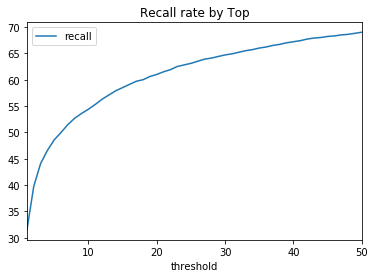

,records_count,true_positives,recall
threshold,,,
1,5001,1798,31.5
2,10002,2271,39.8
3,15003,2517,44.1
4,20004,2656,46.6
5,25005,2769,48.6
6,30006,2853,50.0
7,35007,2936,51.5
8,40008,3006,52.7
9,45009,3058,53.6


In [52]:
df = estimate_performance(results_df, 'rank', range(1, 51, 1), condition='lt')
df['recall'] = df.true_positives.apply(lambda x: round(x / float(gld_ev_sent_count) * 100, 1))
df[['recall']].plot.line(title='Recall rate by Top')
plt.show()
df.head(20)

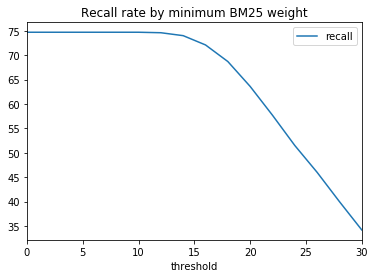

In [22]:
df = estimate_performance(results_df, 'weight', range(0, 31, 2))
df['recall'] = df.true_positives.apply(lambda x: round(x / float(gld_ev_sent_count) * 100, 1))
df[['recall']].plot.line(title='Recall rate by minimum BM25 weight')
plt.show()

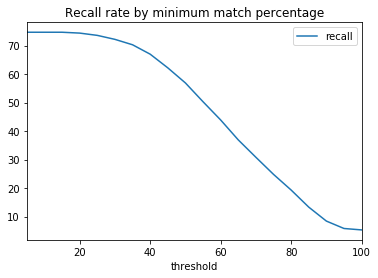

In [23]:
df = estimate_performance(results_df, 'percentage', range(5, 101, 5))
df['recall'] = df.true_positives.apply(lambda x: round(x / float(gld_ev_sent_count) * 100, 1))
df[['recall']].plot.line(title='Recall rate by minimum match percentage')
plt.show()

df = estimate_performance(results_df, 'sentence_symbols_count', range(20, 500, 10))
df['recall'] = df.true_positives.apply(lambda x: round(x / float(gld_ev_sent_count) * 100, 1))
df[['recall']].plot.line(title='Recall rate by minimum symbols length')
plt.show()
df.head(10)

df = estimate_performance(results_df, 'sentence_tokens_count', range(0, 75, 1))
df['recall'] = df.true_positives.apply(lambda x: round(x / float(gld_ev_sent_count) * 100, 1))
df[['recall']].plot.line(title='Recall rate by minimum tokens length')
plt.show()
df.head(10)

## Prepare submission

In [24]:
results_df['evidence'] = results_df.apply(lambda v: (v['found_doc'], v[sentence_col]), axis=1)

mask = (results_df['rank'] <= 5)
submission_df = results_df[mask][['claim_id', 'evidence']]
submission_df = submission_df.groupby('claim_id').agg(list)
submission_df = submission_df.join(claims_df.claim)
submission_df['label'] = "SUPPORTS"

In [25]:
submission_df.to_json('testoutput.json', orient='index')

In [26]:
!python score.py devset.json testoutput.json

Error processing line 2 of /anaconda/lib/python3.6/site-packages/gapic_google_cloud_datastore_v1-0.15.3-py3.6-nspkg.pth:

  Traceback (most recent call last):
    File "/anaconda/lib/python3.6/site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
  KeyError: 'google'

Remainder of file ignored
Label Accuracy 		33.33%
Sentence Precision 	16.61%
Sentence Recall 	67.09%
Sentence F1 		26.63%
Document Precision 	25.28%
Document Recall 	77.83%
Document F1 		38.17%


In [44]:
arecord = [['Edgar_Wright', 6], ['Edgar_Wright', 5], ['Edgar_Wright', 2], ['Edgar_Wright', 1], ['Edgar_Wright', 0], ['Edgar_Wright', 7]]

{(doc_id, sent_id) for doc_id, sent_id in arecord}

{('Edgar_Wright', 0),
 ('Edgar_Wright', 1),
 ('Edgar_Wright', 2),
 ('Edgar_Wright', 5),
 ('Edgar_Wright', 6),
 ('Edgar_Wright', 7)}

In [17]:
import json
import sys

NEI = 'NOT ENOUGH INFO'
actual = json.load(open('devset.json'))
predicted = json.load(open('testoutput.json'))

correct_label = num_instances = 0
evidence_prec = num_eprec = 0
evidence_recall = num_erec = 0
doc_prec = num_dprec = 0
doc_rec = num_drec = 0

for ident, arecord in actual.items():
    precord = predicted[ident]

    alabel = arecord['label'].upper()
    plabel = precord['label'].upper()
    if alabel == plabel:
        correct_label += 1
    num_instances += 1

    if alabel != NEI:
        prec = prec_hits = 0
        #rec = 
        rec_hits = 0

        aes = {(doc_id, sent_id) for doc_id, sent_id in arecord['evidence']}
        pes = {(doc_id, sent_id) for doc_id, sent_id in precord['evidence'][:5]}
        #print()
        for pe in pes:
            #print(pe )
            if pe in aes:
                prec += 1
            prec_hits += 1

        for ae in aes:
            #if ae in pes:
            #    rec += 1
            rec_hits += 1

        #assert prec == rec
        #print(aes)
        ads = set(map(lambda ds: ds[0], aes))
        #print(ads)
        last_pd = None
        dp = ndp = 0
        for pe in pes:
            if not last_pd or pe[0] != last_pd:
                if pe[0] in ads:
                    dp += 1
                ndp += 1
            last_pd = pe[0]

        pds = set(map(lambda ds: ds[0], pes))
        dr = ndr = 0
        for ae in ads:
            if ae in pds:
                dr += 1
            ndr += 1

        if prec_hits > 0:
            evidence_prec += float(prec) / prec_hits
            num_eprec += 1

        if ndp > 0:
            doc_prec += float(dp) / ndp
            num_dprec += 1

        assert rec_hits > 0
        evidence_recall += float(prec) / rec_hits
        num_erec += 1

        assert ndr > 0
        doc_rec += float(dr) / ndr
        num_drec += 1


accuracy = correct_label / float(num_instances)
print('Label Accuracy', '\t\t%.2f%%' % (100 * accuracy))

precision = evidence_prec / float(num_eprec) if num_eprec != 0 else 0
recall = evidence_recall / float(num_erec) if num_erec != 0 else 0
f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
print('Sentence Precision', '\t%.2f%%' % (100 * precision))
print('Sentence Recall', '\t%.2f%%' % (100 * recall))
print('Sentence F1', '\t\t%.2f%%' % (100 * f1))

doc_precision = doc_prec / float(num_dprec) if num_dprec != 0 else 0
doc_recall = doc_rec / float(num_drec) if num_drec != 0 else 0
doc_f1 = 2 * doc_precision * doc_recall / (doc_precision + doc_recall) if doc_precision + doc_recall > 0 else 0
print('Document Precision', '\t%.2f%%' % (100 * doc_precision))
print('Document Recall', '\t%.2f%%' % (100 * doc_recall))
print('Document F1', '\t\t%.2f%%' % (100 * doc_f1))

Label Accuracy 		33.33%
Sentence Precision 	16.61%
Sentence Recall 	67.09%
Sentence F1 		26.63%
Document Precision 	25.04%
Document Recall 	77.83%
Document F1 		37.89%


In [18]:
rec_hits

3

In [ ]:
n